#Section 1. Pulling all the necessary libraries and the repository to colab files

---

### 1.1 Installing and importing libraries

In [ ]:
! pip install torch
! pip install ffmpeg-python
! pip install pydub

import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from torchsummary import summary
from sklearn.preprocessing import LabelEncoder

 ### 1.2 Clone github repository

  - The repository can be found in: [Emotion from speech](https://github.com/onurbil/emotion_from_speech). There you will also find the code and other notebooks on traning and preparing the dataset.
  - The dataset used for training can be found in [Audio emotions](https://www.kaggle.com/uldisvalainis/audio-emotions).
 

In [ ]:
%cd /content
!git clone -l -s https://github.com/onurbil/emotion_from_speech.git emotion_from_speech
%cd emotion_from_speech
!ls
%cd ..

### 1.3 Appending repository to system path

In [ ]:
# Defining the names and variables
REPO_PATH = '/content/emotion_from_speech'
models_path = []
Classes = ["Angry", "Disgusted", "Fearful", "Happy", "Neutral", "Sad", "Surprised"]
audio_name = 'recording'
dataset_path = os.path.join(REPO_PATH, audio_name + '.npy')
model_path = os.path.join(REPO_PATH,'trained_model')
# Appending all the paths of the models
models_path.append([os.path.join(model_path,'GRU_model_71_3973'), 'GRU 1'])
models_path.append([os.path.join(model_path,'GRU_model_73_0390'), 'GRU 2'])
models_path.append([os.path.join(model_path,'LSTMmodel_69_3543'), 'LSTM 1'])
models_path.append([os.path.join(model_path,'LSTMmodel_73_0026'), 'LSTM 2'])

sys.path.append(REPO_PATH)
print(sys.path)

from record_audio import save_audio
from training import load_dataset
from models import Ensemble

### 1.4 Preparing torch to run on the device

In [ ]:
# Preparing the device
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print('Current device:', torch.cuda.get_device_name(device))
else:
    print('Failed to find GPU. Will use CPU.')
    device = 'cpu'

### 1.5 Loading Models


In [ ]:
# Creating emsemble of models
models = []
for path, name in models_path:    
  model = torch.load(path, map_location=torch.device(device))
  models.append([model, name])

Ensemble = Ensemble([model for model, name in models])

# Recording Audio

Here you can record your audio to have your emotion predicted.

***The audio to be recorded is only a 2 seconds audio and it is saved in your colab folder as an .wav file, and is has its features preprocessed as a .npy file***

- First you click to run the cell below(you might need to give your browser permission to use your microfone), and then you will see a button saying "Press to start recording". Whenever you are ready click that button to start your 2 seconds recording.

    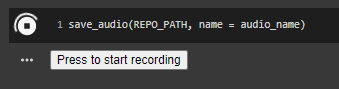

- After it finishes recording you will see a player like the one in the picture below, you can then hear your audio.

    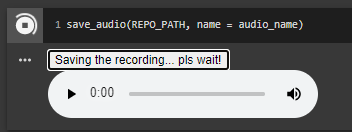





In [ ]:
save_audio(REPO_PATH, name = audio_name)

#Emotion prediction

Here is where the magic happens. It will use the trained model that was retrieved from the github account to predict your emotion.

The emotions that the model was trained are:
- Angry
- Disgusted
- Fearful
- Happy
- Neutral
- Sad
- Surprised

In [ ]:
# Loading recorded audo
data_list = np.load(dataset_path, allow_pickle=True)
train_loader, _, _, _, _ = load_dataset(dataset_path, 1, shuffle_dataset=False)

dataiter = iter(train_loader)
record, labels = dataiter.next()

# Testing the recorded audio with each individual model
for model, name in models:
  model = model.to(device)
  model.eval()
  record = record.to(device)
  y_valid_pred = model(record)
  _, y_valid_pred = torch.max(y_valid_pred.data, 1)
  
  print('\nPredicted emotion for model', name, ': ', Classes[y_valid_pred.data.cpu().numpy()[0]])

# Testing the recorded audio with the ensemble
model = Ensemble.to(device)
model.eval()
record = record.to(device)
y_valid_pred = model(record)
_, y_valid_pred = torch.max(y_valid_pred.data, 1)

print('\nPredicted emotion for ensemble: ', Classes[y_valid_pred.data.cpu().numpy()[0]])